In [1]:
import re
import numpy as np
from numpy import array
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Dense, Embedding, SpatialDropout1D, Flatten, LSTM
from keras.callbacks import EarlyStopping

from sklearn.metrics import roc_auc_score, f1_score, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report

Using TensorFlow backend.


In [2]:
import helper
from helper import preprocessor as pp
from helper import precisionmeasures as pm

In [3]:
font = {'family' : 'sans-serif',
        'style' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.rcParams['figure.figsize'] = 15, 10

In [4]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

In [5]:
class_names = np.array(['Hate','Offensive','Neutral'])
data = pp.load_data('labeled_data.csv')
data['clean_tweet'] = data.tweet.apply(lambda doc: pp.clean_doc(doc))
data.head()


,labels,category,tweet,clean_tweet
0,2,neutral,!!! RT @mayasolovely: As a woman you shouldn't...,woman shouldnt complain cleaning house man alw...
1,1,offensive,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dats coldtyga dwn bad cuffin dat hoe place
2,1,offensive,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg ever fuck bitch start cry confused shit
3,1,offensive,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,look like tranny
4,1,offensive,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,shit hear might true might faker bitch told ya


In [6]:
# Split test and train data 
x_train, y_train= data.clean_tweet[:15000],data.labels[:15000]
x_val, y_val= data.clean_tweet[15000:20000],data.labels[15000:20000]
x_test, y_test = data.clean_tweet[20000:],data.labels[20000:]
# One hot vectors for class labels
y_train_onehot = to_categorical(y_train)
y_val_onehot = to_categorical(y_val)
y_test_onehot = to_categorical(y_test)

In [7]:
# Initializer tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train.append(x_val))
vocab_size = len(tokenizer.word_index)+1
print('Total vocab size: {}'.format(vocab_size))

Total vocab size: 18498


In [8]:
max_length = max([len(tweet.split()) for tweet in x_train.append(x_val)])

sequence_train = tokenizer.texts_to_sequences(x_train)
padded_train = pad_sequences(sequence_train, maxlen=max_length, padding='post') 

sequence_val = tokenizer.texts_to_sequences(x_val)
padded_val = pad_sequences(sequence_val, maxlen=max_length, padding='post') 

sequence_test = tokenizer.texts_to_sequences(x_test)
padded_test = pad_sequences(sequence_test, maxlen=max_length, padding='post') 

In [9]:
# Load Enbedding Matrix
embedding_matrix = pd.read_pickle("GloVe_matrix.pkl").values

# LSTM 

In [10]:
embed_dim = 300 # Word Embedding Dimension

# Model definition
model = Sequential()
model.add(Embedding(vocab_size, embed_dim, weights=[embedding_matrix], input_length=max_length, trainable=True))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, return_sequences=True))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
print(model.summary())

# Model compilation
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

# Early stopping based on validation loss
es = EarlyStopping(monitor='val_loss',patience=8)

# Fitting the model on training and validation data
history = model.fit(padded_train,y_train_onehot,
                    epochs=10,
                    batch_size=128,
                    validation_data=(padded_val, y_val_onehot),
                    callbacks=[es],
                    verbose=2)

# Model predictions
y_pred_prob = model.predict(padded_test)
y_pred = np.argmax(y_pred_prob,axis=1)
y_pred_onehot = to_categorical(y_pred)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 26, 300)           5549400   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 26, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 26, 300)           721200    
_________________________________________________________________
flatten_1 (Flatten)          (None, 7800)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 23403     
Total params: 6,294,003
Trainable params: 6,294,003
Non-trainable params: 0
___________

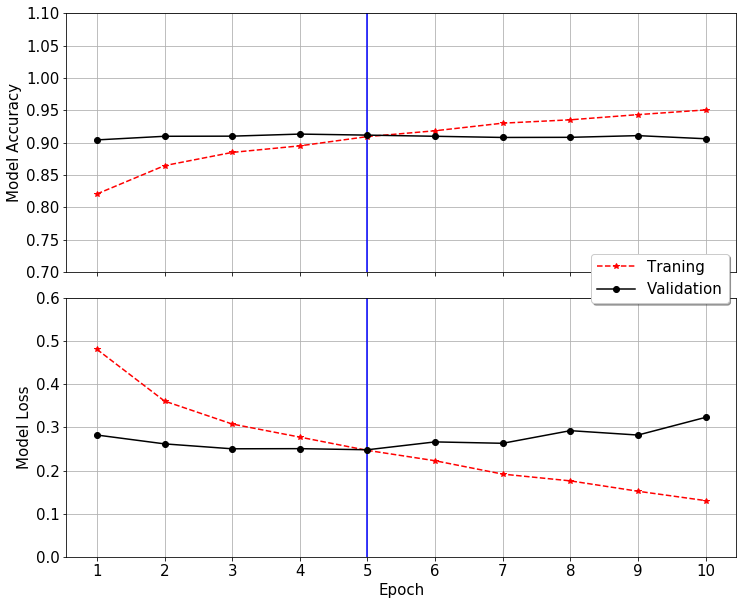

In [11]:
# Plot the training and validation accuracy and loss score

# Epoch with min loss
epoch_val_loss = np.argmin(history.history['val_loss'])

# Compute the min-max loss for plotting. Buffer 0.1 is for clear plot
min_loss = np.round(min(history.history['loss']+history.history['val_loss']),1)-0.1
max_loss = np.round(max(history.history['loss']+history.history['val_loss']),1)+0.1

# Compute the min-max acc for plotting. Buffer 0.1 is for clear plot
min_acc = np.round(min(history.history['acc']+history.history['val_acc']),1)-0.1
max_acc = np.round(max(history.history['acc']+history.history['val_acc']),1)+0.1

fig, (ax1,ax2) = plt.subplots(2,1,figsize = (12,10),sharex = True)
ax1.plot(history.history['acc'],'r*--')
ax1.plot(history.history['val_acc'],'ko-')
ax1.set(ylabel = 'Model Accuracy',
        xlabel = '',
        xticks = np.arange(1,10),
        ylim = [min_acc,max_acc])
ax1.grid()
ax1.vlines(epoch_val_loss,min_acc,max_acc, color = 'b')

ax2.plot(history.history['loss'],'r*--')
ax2.plot(history.history['val_loss'],'ko-')
ax2.set(ylabel = 'Model Loss',
        xlabel = 'Epoch',
        xticks = np.arange(0,10),
        xticklabels = np.arange(1,11),
        ylim = [min_loss,max_loss])
ax2.vlines(epoch_val_loss,min_loss,max_loss, color = 'b')
ax2.grid()
ax2.legend(['Traning', 'Validation'], loc='best',
           bbox_to_anchor=(1.0, 1.2),shadow=True, handlelength=2.5)
plt.subplots_adjust(hspace=0.1)
plt.show()

In [12]:
print('='*10,'Classification Report','='*10)
cr = classification_report(y_test_onehot, y_pred_onehot,target_names=class_names,output_dict=True)
cr['Hate'].update({'PR_auc' : average_precision_score(y_test_onehot[:,0], y_pred_prob[:,0],average='micro')} )
cr['Offensive'].update({'PR_auc' : average_precision_score(y_test_onehot[:,1], y_pred_prob[:,1],average='micro')} )
cr['Neutral'].update({'PR_auc' : average_precision_score(y_test_onehot[:,2], y_pred_prob[:,2],average='micro')} )
cr['micro avg'].update({'PR_auc' : average_precision_score(y_test_onehot, y_pred_prob,average='micro')})
cr['macro avg'].update({'PR_auc' : average_precision_score(y_test_onehot, y_pred_prob,average='macro')})
cr['weighted avg'].update({'PR_auc' : average_precision_score(y_test_onehot, y_pred_prob,average='weighted')})
cr['samples avg'].update({'PR_auc' : average_precision_score(y_test_onehot, y_pred_prob,average='samples')})
score_matrix = pd.DataFrame.from_dict(cr).T
score_matrix

========== Classification Report ==========


,PR_auc,f1-score,precision,recall,support
Hate,0.382469,0.404878,0.453552,0.365639,227.0
Offensive,0.983171,0.949375,0.949001,0.949750,3801.0
Neutral,0.915308,0.865248,0.842965,0.888742,755.0
micro avg,0.963747,0.912398,0.912398,0.912398,4783.0
macro avg,0.760316,0.739834,0.748506,0.734710,4783.0
weighted avg,0.943949,0.910254,0.908749,0.912398,4783.0
samples avg,0.953760,0.912398,0.912398,0.912398,4783.0


Normalized confusion matrix
[[0.36563877 0.52422907 0.11013216]
 [0.02394107 0.94975007 0.02630887]
 [0.01192053 0.09933775 0.88874172]]
Average precision score, micro-averaged over all classes: 0.96


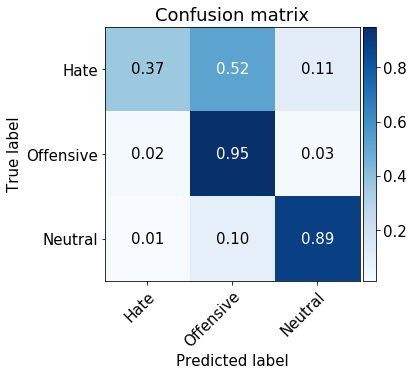

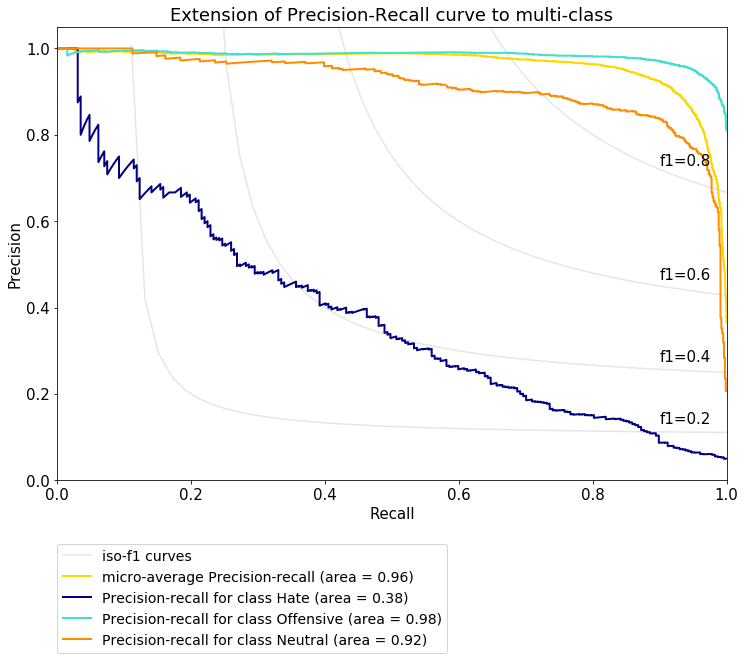

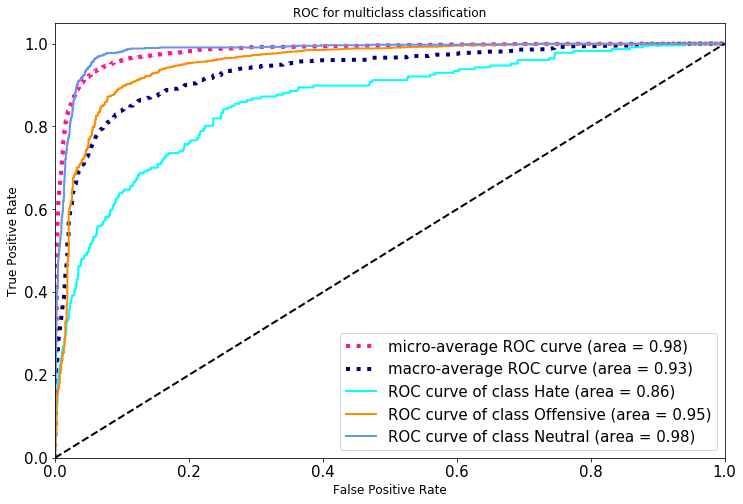

In [13]:
# Model confusion matrix
pm.plot_confusion_matrix(y_test.values, y_pred, classes=class_names,normalize = True,
                      title='Confusion matrix');
# Precision - Recall Curve
pm.prec_recall_curve(y_test_onehot, y_pred_prob,class_names)
# Reciever operator Curve
roc_auc = pm.ROC_curve(y_test_onehot, y_pred_prob,3)